In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [9]:
dir_path = '../results/filtered_samples/concated/'

In [10]:
os.listdir(dir_path)

['chimp.h5ad', 'human.h5ad', 'macaque.h5ad', 'spatial_libd_human.h5ad']

##  Make pseudobulk

In [32]:
from tqdm.notebook import tqdm
expr_dict = dict()
ann_dict = dict()
for file_name in tqdm(os.listdir(dir_path)):
    file = file_name.split('.')[0]
    # read adata object
    adata = sc.read_h5ad(dir_path + file_name)
    adata.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
    # add pseudobulk label
    adata.obs['pb_label'] = adata.obs.label.astype(str) + '.' + adata.obs.sample_id.astype(str)
    # create pseudobulk df
    sample_layer_list = adata.obs.pb_label.unique().tolist()
    pb_list = [adata[adata.obs.pb_label == sample].X.mean(axis=0) for sample in sample_layer_list]
    pb_df = pd.DataFrame(np.concatenate(pb_list).T, columns=sample_layer_list, index=adata.var_names)
    expr_dict[file] = pb_df
    # create annotation file
    columns = ['layer', 'sample_id']
    annotation_list = [sample.split('.') for sample in sample_layer_list]
    annotation = pd.DataFrame(annotation_list, index=sample_layer_list, columns=columns)
    annotation['condition'] = file
    ann_dict[file] = annotation
    #save files
    pb_df.to_csv(f'../results/DiffExpr/pseudobulks/expression_{file}.csv')
    annotation.to_csv(f'../results/DiffExpr/pseudobulks/annotation_{file}.csv')

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## PCA

In [33]:
# create adata objects
adata_dict = dict()
for file in expr_dict.keys():
    adata = an.AnnData(expr_dict[file].T)
    adata.obs = ann_dict[file]
    adata_dict[file] = adata

In [34]:
adata = an.concat(list(adata_dict.values()), merge='same')
adata

AnnData object with n_obs × n_vars = 170 × 15367
    obs: 'layer', 'sample_id', 'condition'

In [35]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [36]:
adata.obs.sample_id

L3.chimp_11454    chimp_11454
L6.chimp_11454    chimp_11454
L5.chimp_11454    chimp_11454
L4.chimp_11454    chimp_11454
L2.chimp_11454    chimp_11454
                     ...     
WM.151676              151676
L6.151676              151676
L5.151676              151676
L2.151676              151676
L4.151676              151676
Name: sample_id, Length: 170, dtype: object

In [37]:
adata.obs["lib_size"] = adata.X.sum(axis=1)
adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


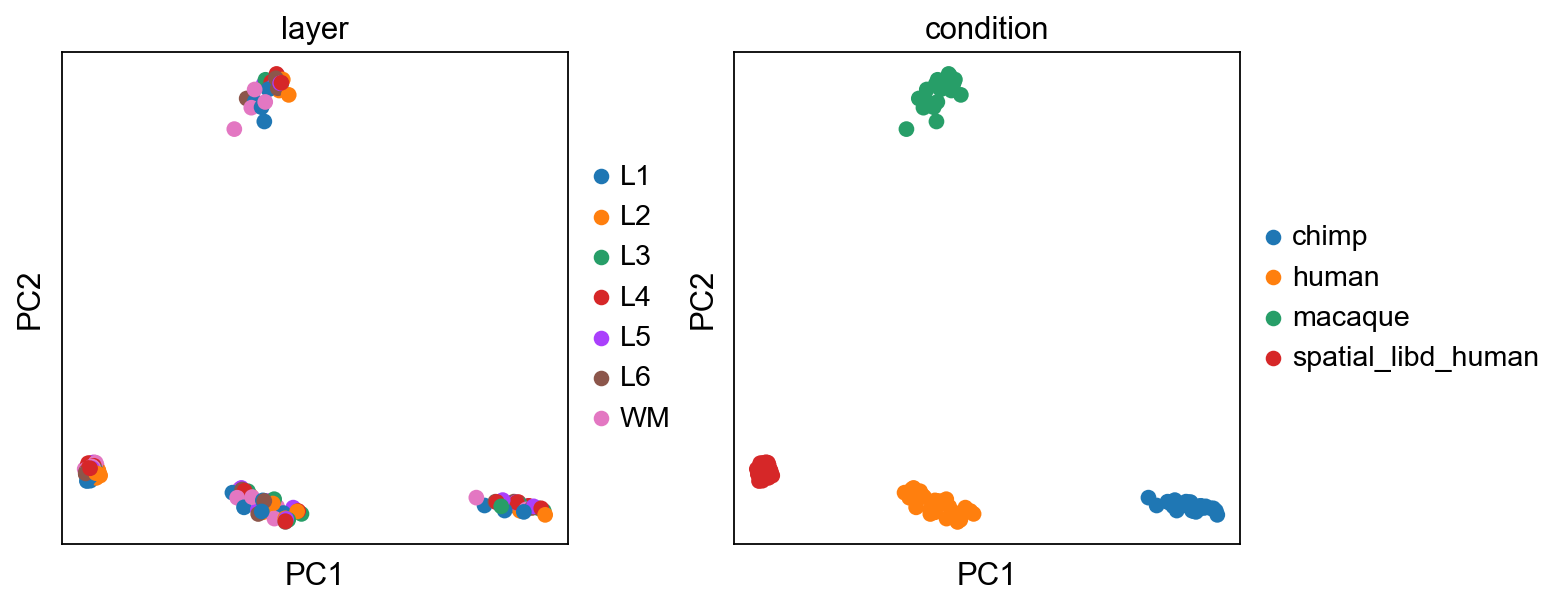

In [42]:
sc.pl.pca(adata, color=['layer', 'condition'], size=200, ncols=2)

Очень сильный батч эффект, конечно

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via '

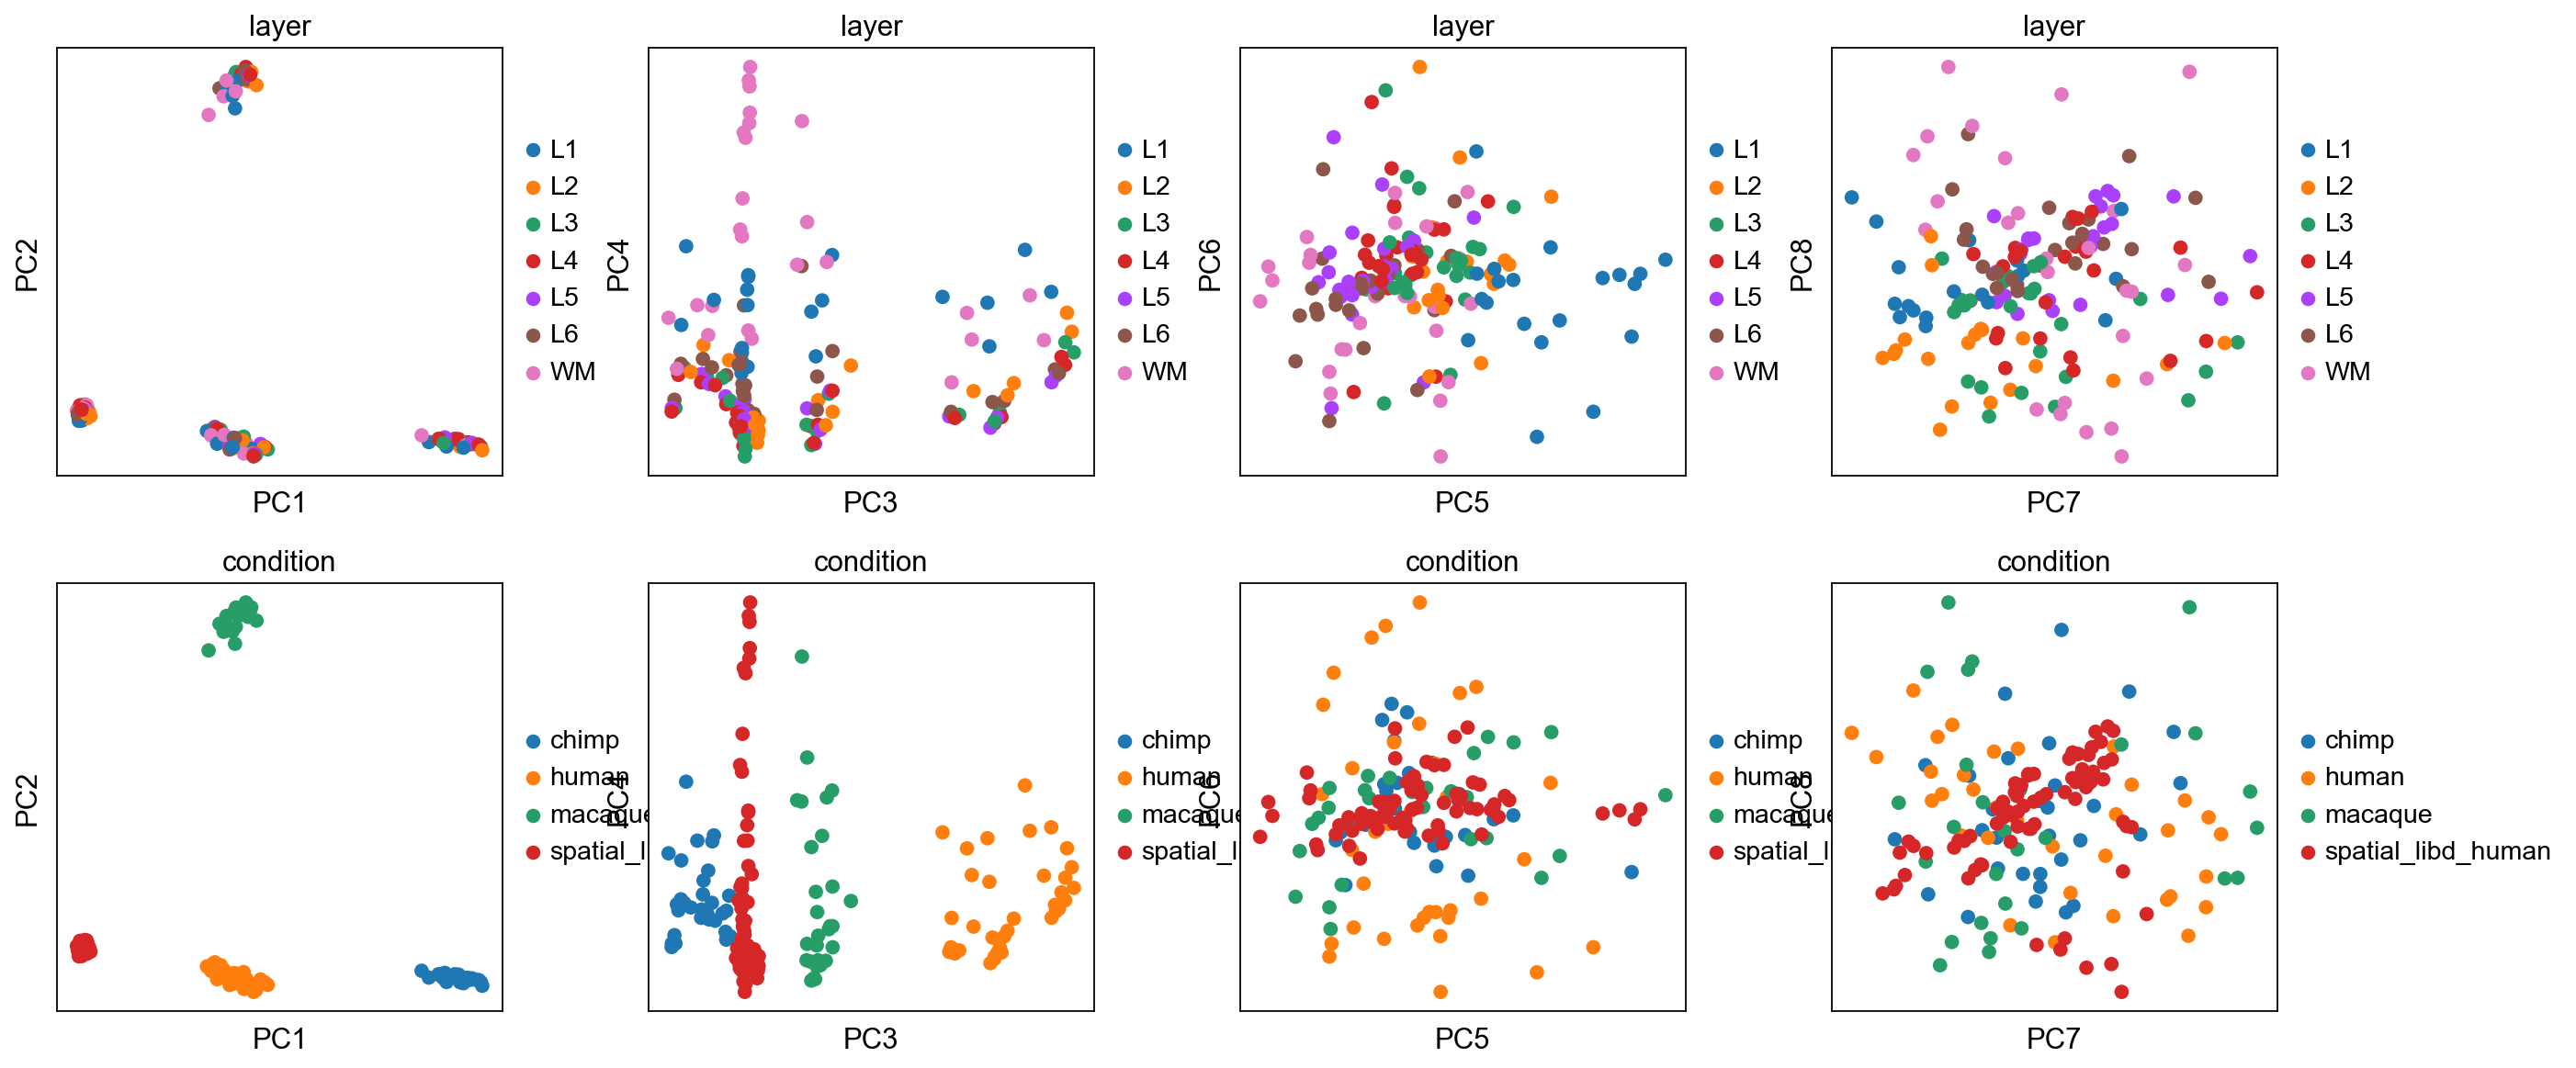

In [44]:
sc.pl.pca(adata, color=['layer', 'condition'], components = ['1,2','3,4','5,6','7,8'], size=200)

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


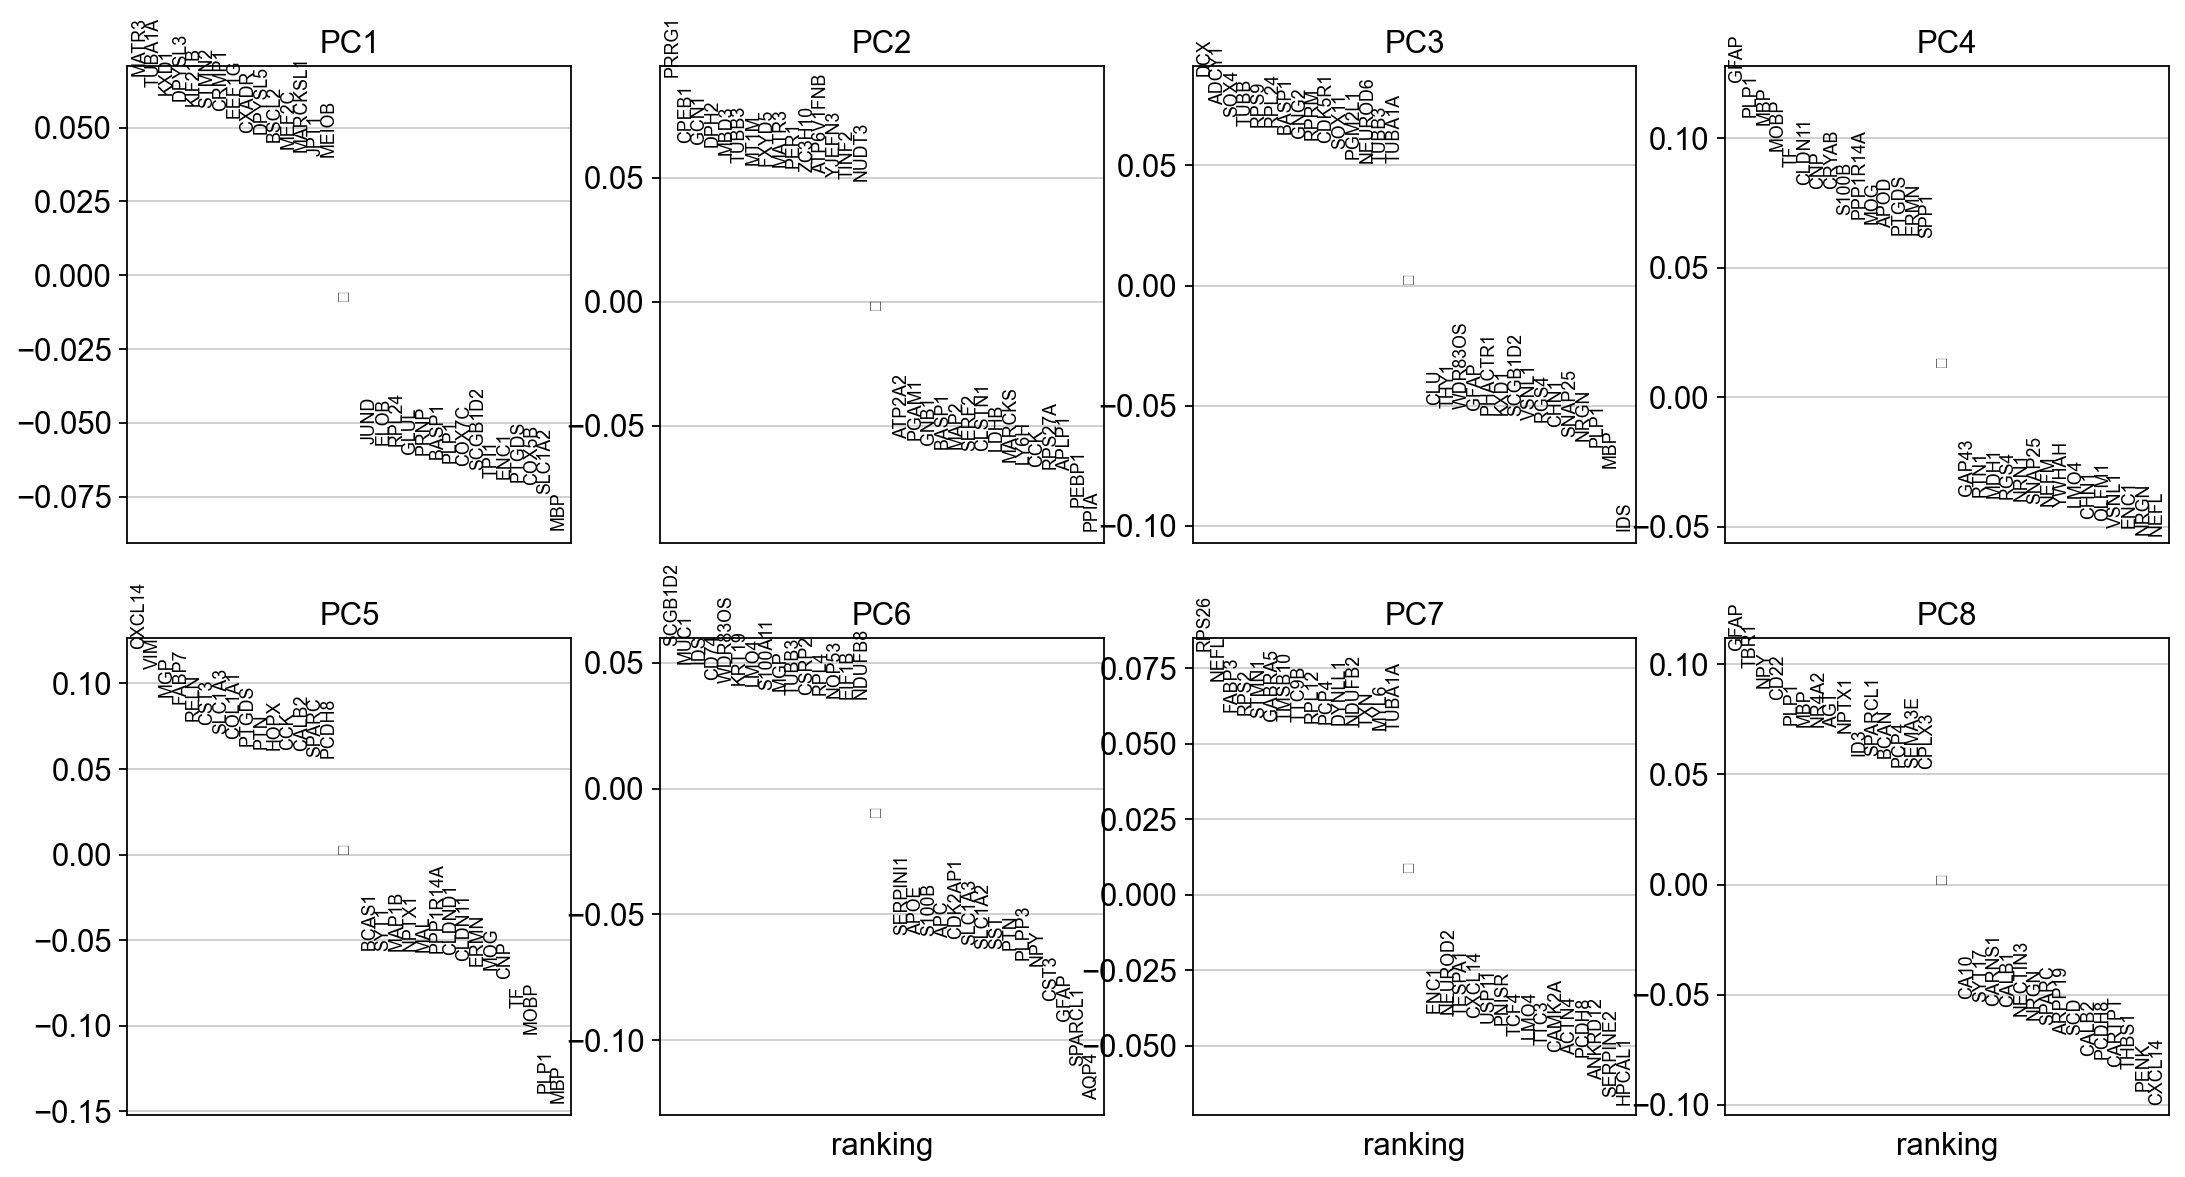

In [41]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

## Normed pseudobulk

In [83]:
adata_norm = adata.copy()

In [60]:
gene_mean_list = []
sample_layer_list = adata.obs.sample_id.unique().tolist()
for sample in sample_layer_list:
    gene_mean_list.append(adata[adata.obs.sample_id == sample].X.mean(axis=0).reshape(-1, 1))

In [64]:
gene_mean_df = pd.DataFrame(np.concatenate(gene_mean_list, axis=1), columns=sample_layer_list, index=adata.var_names)
gene_mean_df.head()

,chimp_11454,chimp_13302,chimp_13309,chimp_j11,chimp_j8,human_759,human_j12,human_j3,human_j4,human_j6,...,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676
RNF223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000386,0.000000,0.000000,...,0.001837,0.001609,0.000000,0.000724,0.010476,0.009707,0.002949,0.003104,0.002337,0.003959
TTLL10,0.000000,0.001968,0.002780,0.006162,0.002706,0.001494,0.000000,0.001019,0.000450,0.000000,...,0.000344,0.000000,0.004733,0.000000,0.003722,0.000707,0.000000,0.000000,0.002534,0.002585
TNFRSF18,0.000000,0.001728,0.000000,0.000000,0.000277,0.003367,0.001963,0.002794,0.000000,0.000000,...,0.150463,0.133267,0.089664,0.070198,0.136578,0.091692,0.059650,0.133289,0.105160,0.097579
SDF4,0.007906,0.008213,0.007303,0.042232,0.006871,0.575642,0.681122,0.738712,0.748846,0.740912,...,0.831182,0.787612,0.722643,0.729835,0.819475,0.807983,0.853221,0.811984,0.778592,0.786189
B3GALT6,0.000000,0.005045,0.000635,0.007279,0.001063,0.624075,0.532617,0.695559,0.707982,0.452548,...,0.360400,0.389300,0.389483,0.315279,0.382709,0.411795,0.421578,0.413975,0.449844,0.447922


In [109]:
adata[adata.obs.sample_id == sample].obs.index.tolist()

['L3.151676',
 'L1.151676',
 'WM.151676',
 'L6.151676',
 'L5.151676',
 'L2.151676',
 'L4.151676']

In [111]:
for sample in sample_layer_list:
    columns = adata[adata.obs.sample_id == sample].obs.index.tolist()
    for column in columns:
        adata_norm[column].X = adata_norm[column].X - gene_mean_df.loc[:, sample].values

In [117]:
np.isnan(adata_norm.X).sum()

0

## PCA

In [119]:
#sc.pp.normalize_total(pb_adata, target_sum=1e4)
#sc.pp.log1p(pb_adata)
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


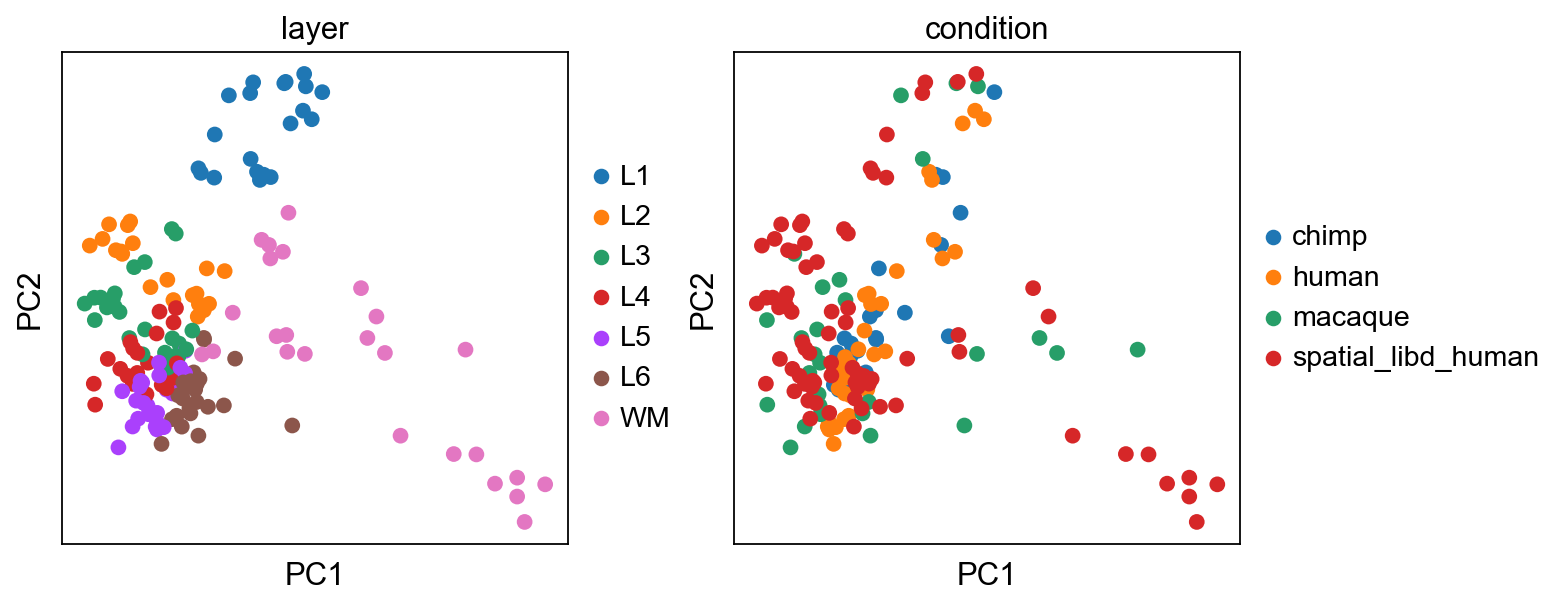

In [121]:
sc.pl.pca(adata_norm, color=['layer', 'condition'], size=200, ncols=2)

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


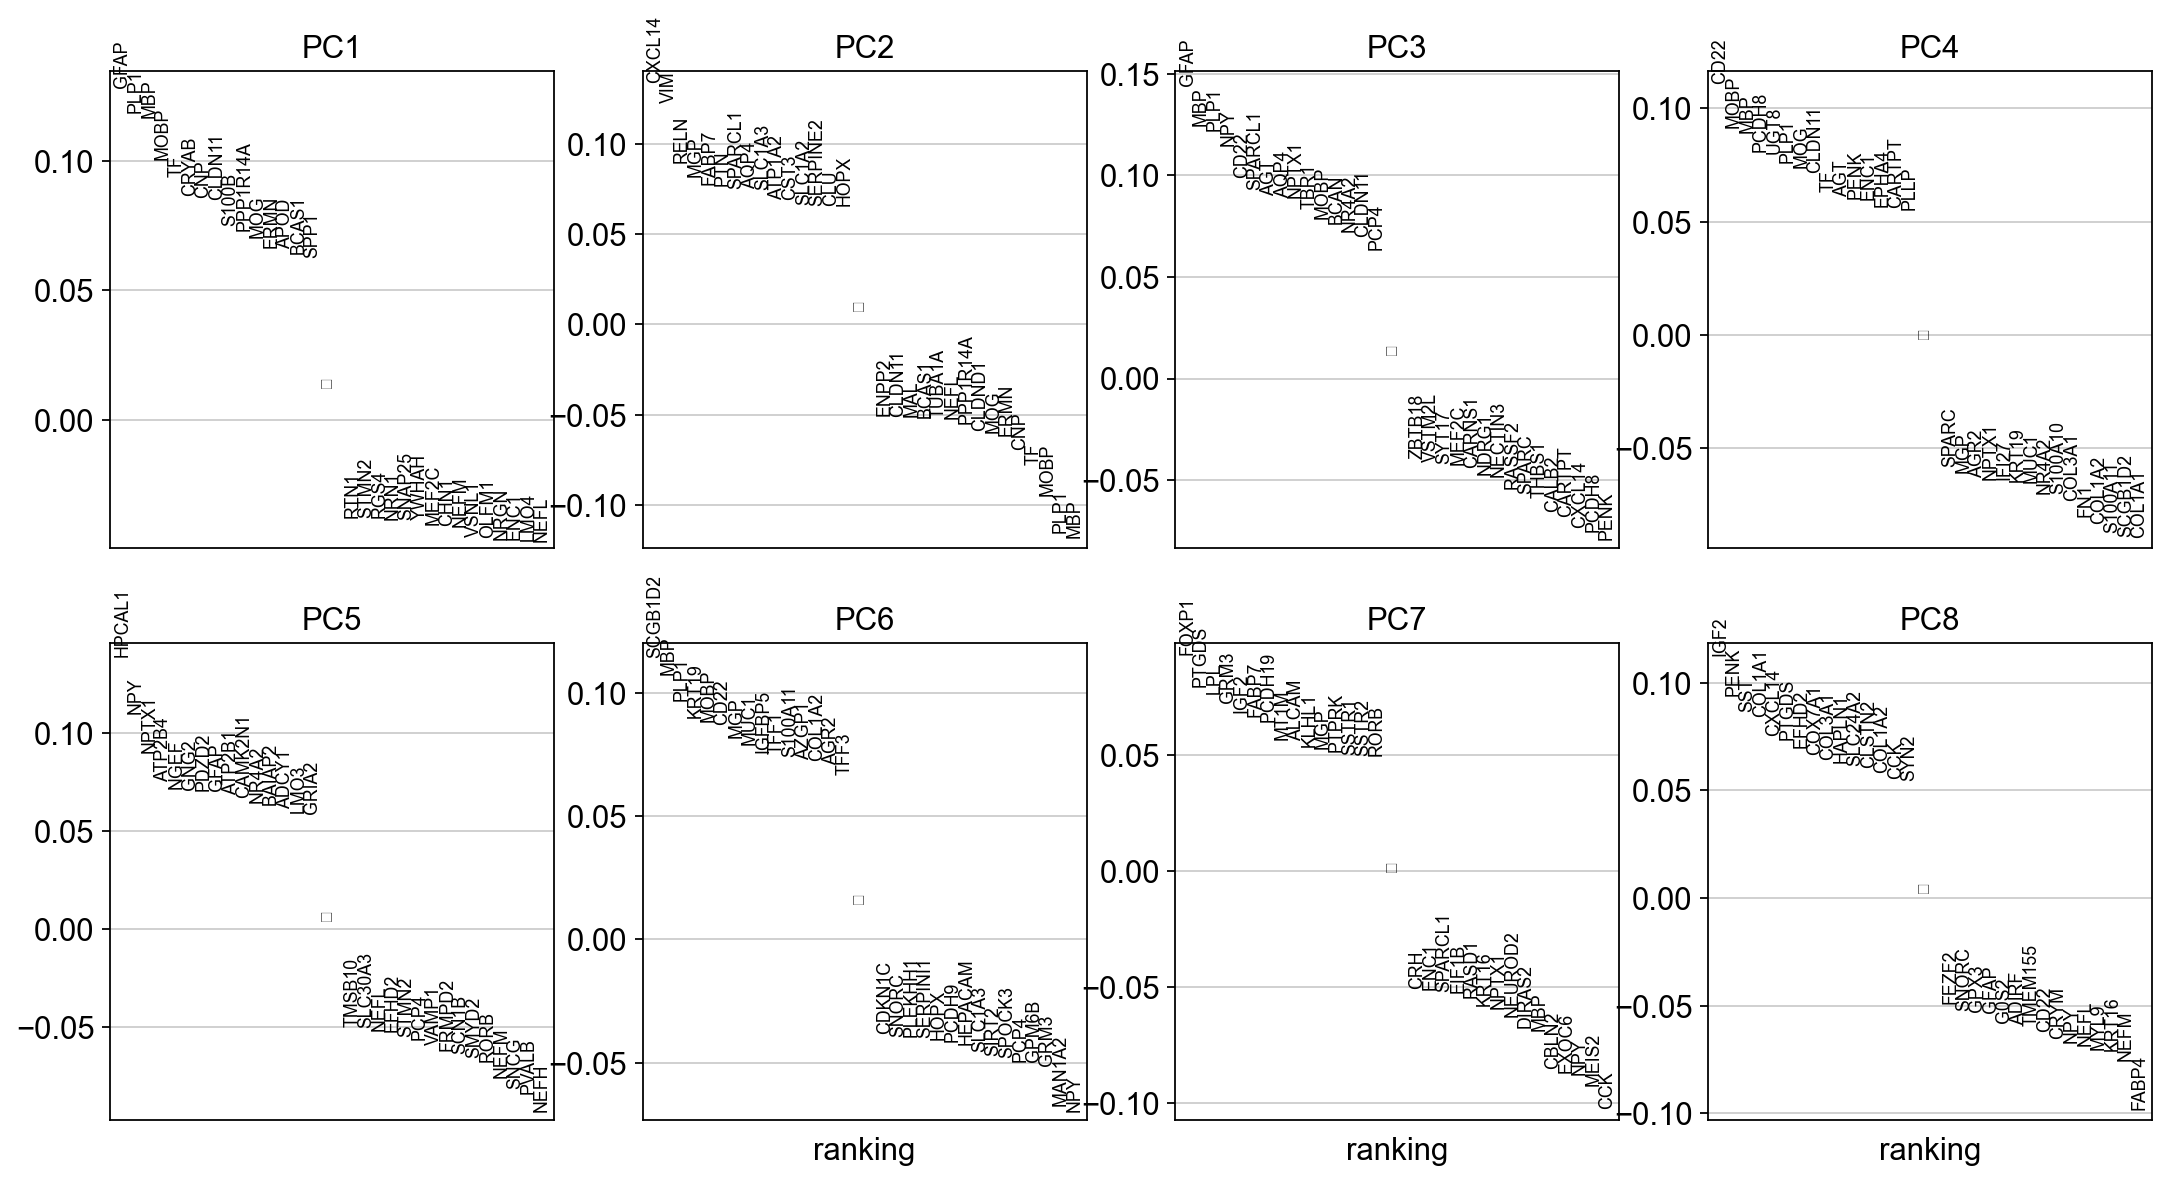

In [123]:
sc.pl.pca_loadings(adata_norm, components=[1,2,3,4,5,6,7,8])